# MARS SPECTROMETRY 2: GAS CHROMATOGRAPHY - BENCHMARK

_Did Mars ever have environmental conditions that could have supported life?_ This is one of the key questions in the field of planetary science. NASA missions like the Curiosity and Perseverance rovers have a rich array of capabilities that can help answer this question, one of which is collecting rock and soil samples and taking measurements that can be used to determine their chemical makeup. These samples can be analyzed for chemical signatures that indicate the environment's habitability, or potentially even signs of microbial life directly.

The aim of this work is to build a model to automatically analyze mass spectrometry data for geological samples of scientific interest in understanding the present and past habitability of Mars. Specifically, the model should detect the presence of certain families of chemical compounds in data collected from performing gas chromatography–mass spectrometry (GCMS) on a set of geological material samples.

[Reference](https://drivendata.co/blog/mars-spectrometry-gcms-benchmark)

### LIBRARIES

In [1]:
import random
import pandas as pd
import numpy as np
from pathlib import Path
from pprint import pprint

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import make_scorer, log_loss
from sklearn.model_selection import StratifiedKFold, cross_val_score

from tqdm import tqdm
import msgc

In [2]:
RANDOM_SEED = 42
tqdm.pandas()

### DATA

In [3]:
metadata = pd.read_csv("data/metadata.csv", index_col="sample_id")

In [4]:
train_files = metadata[metadata["split"] == "train"]["features_path"].to_dict()
val_files = metadata[metadata["split"] == "val"]["features_path"].to_dict()
test_files = metadata[metadata["split"] == "test"]["features_path"].to_dict()

## EXPLORATORY DATA ANALYSIS

### MASS SPECTRUM

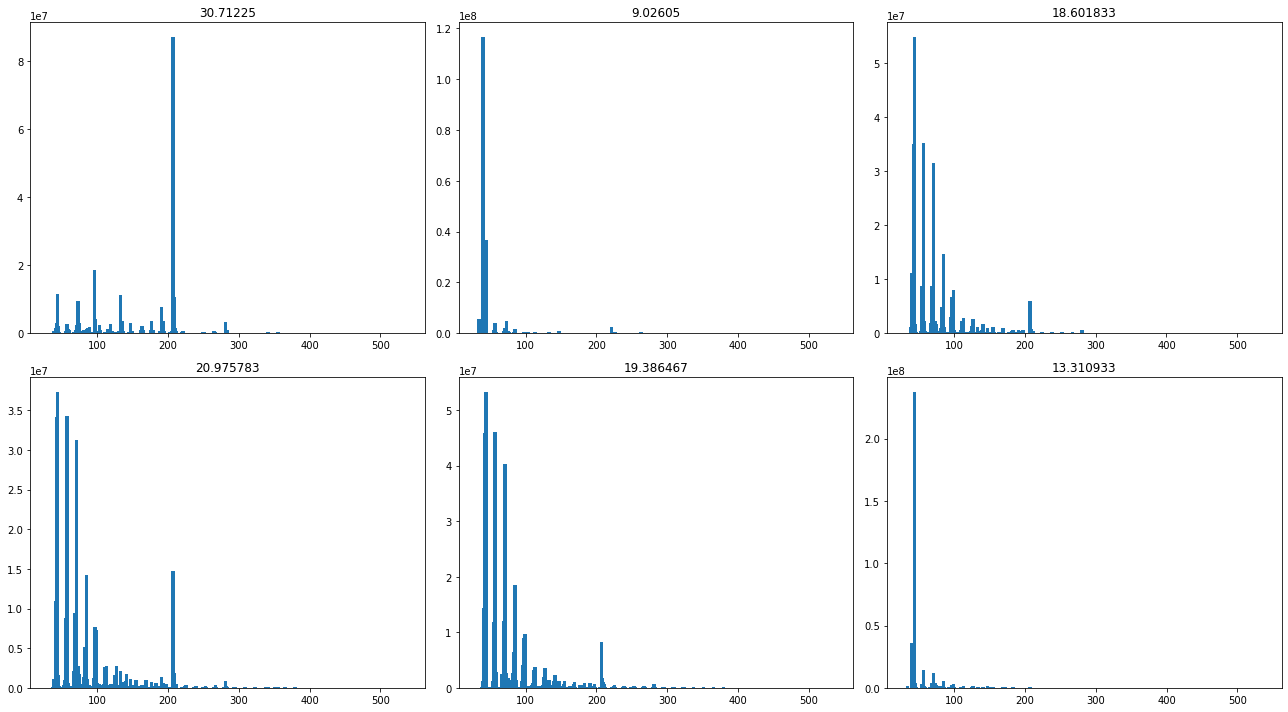

In [5]:
sample = pd.read_csv("data/train_features/S0002.csv") # Test sample.
msgc.viz.grid_plot(sample, msgc.viz.plot_mass_spectrum, random.sample(list(sample.time.unique()), 6), cols=3) # Plot

### SPECTOGRAMS

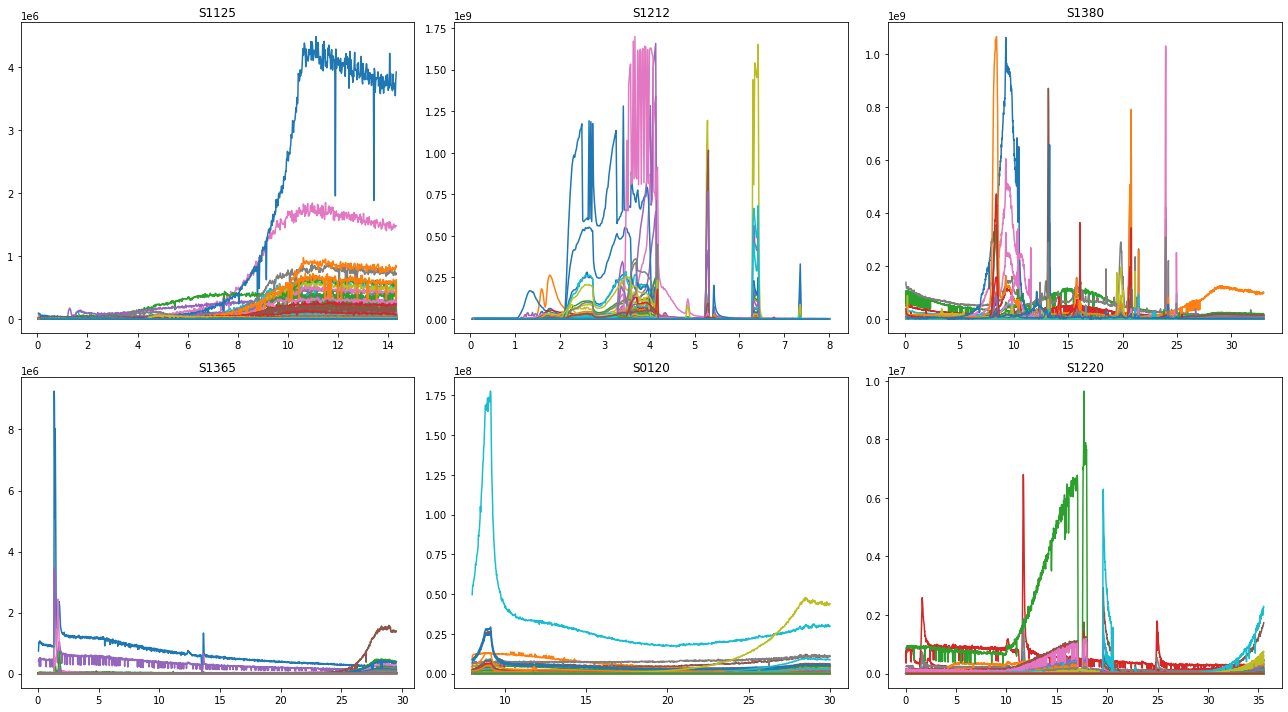

In [6]:
msgc.viz.grid_plot(metadata, msgc.viz.plot_spectrogram, random.sample(list(metadata.index), 6), cols=3)

- There is a diversity in the time range of experiments (some are as short as 7 minutes, while others extend to nearly 40), and the intensity ranges differ as well.
- There are different m/z ion types that peak at different times. (Each colored line represents a distinct m/z value).
- For some samples, there are other ion types that are consistently present at low abundance levels. These are likely background abundances that are irrelevant. (In general, a spectrogram is useful for the peaks in abundances it shows at different times).

### MISC

Derivatized

In [7]:
metadata.derivatized.value_counts(dropna=False)
# NaN doesn't mean not, it simply means unknown.

NaN    1023
1.0     561
Name: derivatized, dtype: int64

Train labels

In [8]:
train_labels = pd.read_csv("data/train_labels.csv", index_col="sample_id")
target_cols = train_labels.columns
train_labels.columns

Index(['aromatic', 'hydrocarbon', 'carboxylic_acid',
       'nitrogen_bearing_compound', 'chlorine_bearing_compound',
       'sulfur_bearing_compound', 'alcohol', 'other_oxygen_bearing_compound',
       'mineral'],
      dtype='object')

1. aromatic: sample contains aromatic compounds
1. hydrocarbon: sample contains hydrocarbon compounds
1. carboxylic_acid: sample contains carboxylic acid compounds, such as amino acids
1. nitrogen_bearing_compound: sample contains nitrogen-containing compounds, such as amines or nitriles
1. chlorine_bearing_compound: sample contains chlorine
1. sulfur_bearing_compound: sample contains sulfur
1. alcohol: sample contains alcohol compounds
1. other_oxygen_bearing_compound: sample contains compounds that contain oxygen but are not carboxylic acids or alcohols, such as esters and ethers
1. mineral: sample contains mineral compounds

In [9]:
train_labels.aggregate("sum", axis=1).value_counts(normalize=True)

1    0.473424
0    0.374536
2    0.071693
3    0.046972
4    0.016069
8    0.013597
5    0.003708
dtype: float64

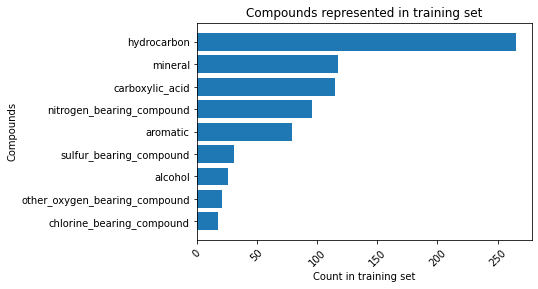

In [10]:
sumlabs = train_labels.aggregate("sum").sort_values()

plt = msgc.viz.plt
plt.barh(sumlabs.index, sumlabs, align="center")
plt.ylabel("Compounds")
plt.xticks(rotation=45)
plt.xlabel("Count in training set")
plt.title("Compounds represented in training set");

- A large share (about 37 percent) of our samples do not have a positive label for any of the classes, and
- For some classes, such as chlorine-bearing compounds, other oxygen-bearing compounds, alcohols, and sulfur-bearing compounds, we have very few samples (less than 50).

## PREPROCESSING

In [11]:
# Train sample.
sample_paths_ls = metadata[metadata["split"] == "train"].features_path
training_stats = pd.DataFrame(sample_paths_ls)
training_stats.columns = ["fpath"]

In [12]:
# (
#     training_stats["time_min"],
#     training_stats["time_max"],
#     training_stats["time_range"],
#     training_stats["mass_min"],
#     training_stats["mass_max"],
#     training_stats["mass_range"],
# ) = zip(*training_stats['fpath'].progress_apply(msgc.features.get_time_mass_stats))

In [13]:
# training_stats.describe()

### 1. Standardizing which m/z values to include

In [14]:
sample_ = msgc.features.drop_frac_and_He(sample)

In [15]:
sample.head()

,time,mass,intensity
0,7.002083,33.209106,903181.0
1,7.002083,33.961044,3876882.0
2,7.002083,35.105576,32380.0
3,7.002083,35.925064,257204.0
4,7.002083,37.095093,100347.0


### 2. Removing background ion presences

In [16]:
# pass

### 3. Convert abundances to relative abundances

In [17]:
# Standardization

## FEATURE ENGINEERING
Expecting 350 m/z values * 50 time bins = 17,500 features to be generated per sample.

In [18]:
train_files = metadata[metadata.split=="train"].features_path.to_dict()

In [19]:
train_features_dict = {}

# Assembling preprocessed and transformed training set.
for sample_id, filepath in tqdm(train_files.items()):
    # Load training sample.
    temp = pd.read_csv(f"data/{filepath}")
    
    # Preprocessing. 
    train_sample_pp = msgc.features.preprocess_sample(temp).reset_index(drop=True)
    
    # Feature engineering. 
    train_sample_fe = msgc.features.int_per_timebin(train_sample_pp)
    train_features_dict[sample_id] = train_sample_fe

100%|████████████████████████████████████████████████████████████████████████████████| 809/809 [22:17<00:00,  1.65s/it]


In [20]:
train_features = pd.concat(
    train_features_dict, names=["sample_id", "dummy_index"]
).reset_index(level="dummy_index", drop=True)

## MODELING

In [21]:
# Define stratified k-fold validation
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

# Define log loss
log_loss_scorer = make_scorer(log_loss, needs_proba=True)

### Baseline dummy classifier

In [22]:
# Check log loss score for baseline dummy model
def logloss_cross_val(clf, X, y):

    # Generate a score for each label class
    log_loss_cv = {}
    for col in y.columns:

        y_col = y[col]  # take one label at a time
        log_loss_cv[col] = np.mean(
            cross_val_score(clf, X.values, y_col, cv=skf, scoring=log_loss_scorer)
        )

    avg_log_loss = np.mean(list(log_loss_cv.values()))

    return log_loss_cv, avg_log_loss

In [23]:
# Dummy classifier
dummy_clf = DummyClassifier(strategy="prior")

print("Dummy model cross-validation average log-loss:")
dummy_logloss = logloss_cross_val(dummy_clf, train_features, train_labels[target_cols])
pprint(dummy_logloss[0])
print("\nAggregate log-loss")
dummy_logloss[1]

Dummy model cross-validation average log-loss:
{'alcohol': 0.14214942747285955,
 'aromatic': 0.31989530853732984,
 'carboxylic_acid': 0.40885054104150764,
 'chlorine_bearing_compound': 0.10676820510533594,
 'hydrocarbon': 0.6324429889239704,
 'mineral': 0.4132828599514662,
 'nitrogen_bearing_compound': 0.3642707864294015,
 'other_oxygen_bearing_compound': 0.12046121550466556,
 'sulfur_bearing_compound': 0.16260642339623016}

Aggregate log-loss


0.2967475284847519

### Logistic regression model

In [24]:
# Define Lasso model
logreg_clf = LogisticRegression(penalty="l1", solver="liblinear", C=2)
print("Logistic regression model cross-validation average log-loss:\n")
logreg_logloss = logloss_cross_val(logreg_clf, train_features, train_labels[target_cols])
pprint(logreg_logloss[0])
print("Aggregate log-loss")
logreg_logloss[1]

Logistic regression model cross-validation average log-loss:

{'alcohol': 0.11337939329010141,
 'aromatic': 0.23803606642254033,
 'carboxylic_acid': 0.266941582903965,
 'chlorine_bearing_compound': 0.08057827268329507,
 'hydrocarbon': 0.24151005341397927,
 'mineral': 0.24246563707098062,
 'nitrogen_bearing_compound': 0.2231323048895811,
 'other_oxygen_bearing_compound': 0.08583863069988198,
 'sulfur_bearing_compound': 0.10407213675033404}
Aggregate log-loss


0.17732823090273986

### Training the model on all of the data

In [25]:
# Train logistic regression model with l1 regularization, where C = 2
def logreg_train(X_train, y_train):

    # Initialize dict to hold fitted models
    logreg_model_dict = {}

    # Split into binary classifier for each class
    for col in y_train.columns:

        y_train_col = y_train[col]  # Train on one class at a time

        # Output the trained model, bind this to a var, then use as input to prediction function
        clf = LogisticRegression(penalty="l1", solver="liblinear", C=2, random_state=42)

        logreg_model_dict[col] = clf.fit(X_train.values, y_train_col)  # Train

    return logreg_model_dict

In [26]:
fitted_logreg_dict = logreg_train(train_features, train_labels[target_cols])

### Preparing a submission

In [27]:
# Create dict with both validation and test sample IDs and paths
all_test_files = val_files
all_test_files.update(test_files)
print("Total test files: ", len(all_test_files))

Total test files:  775


In [28]:
# Import submission format
submission_template_df = pd.read_csv(
   "data/submission_format.csv", index_col="sample_id"
)
compounds_order = submission_template_df.columns
sample_order = submission_template_df.index

In [31]:
def predict_for_sample(sample_id, fitted_model_dict):

    # Import sample
    temp_sample = pd.read_csv(f'data/{all_test_files[sample_id]}')

    # Preprocess sample
    temp_sample = msgc.features.preprocess_sample(temp_sample)

    # Feature engineering on sample
    temp_sample = msgc.features.int_per_timebin(temp_sample)

    # Generate predictions for each class
    temp_sample_preds_dict = {}

    for compound in compounds_order:
        clf = fitted_model_dict[compound]
        temp_sample_preds_dict[compound] = clf.predict_proba(temp_sample.values)[:, 1][0]

    return temp_sample_preds_dict

In [ ]:
# Dataframe to store logreg submissions in
final_submission_df = pd.DataFrame(
    [
        predict_for_sample(sample_id, fitted_logreg_dict)
        for sample_id in sample_order
    ],
    index=sample_order,
)

In [ ]:
final_submission_df.head()

In [ ]:
# Check that columns and rows are the same between final submission and submission format
assert final_submission_df.index.equals(submission_template_df.index)
assert final_submission_df.columns.equals(submission_template_df.columns)

In [ ]:
final_submission_df.to_csv("benchmark_logreg_c2_submission.csv")